##### TextPreprocessing+Word2Vec+ Machine Learning Classifier

**Import Libraries**

In [27]:
### For computational and random seed purpose
import numpy as np
np.random.seed(42)
#to read csv file
import pandas as pd
#To split into train and cv data
from sklearn.model_selection import train_test_split
#To compute AUROC
from sklearn.metrics import auc,roc_auc_score
#for AUROC graph
import matplotlib.pyplot as plt
#for oversampling technique
from imblearn.over_sampling import SMOTE # (https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html)
#Data is imbalanced, we need calibrated model
from sklearn.calibration import CalibratedClassifierCV
#for hyperparameter tuning and Cross-validation fold
from sklearn.model_selection import GridSearchCV,StratifiedKFold,RepeatedStratifiedKFold
#to ignore the error message
import warnings
warnings.filterwarnings("ignore")
#for heatmap and other plotting technique
import seaborn as sns
#to strandize the real value data
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.preprocessing import LabelEncoder
#To create Knn model on datasets
from sklearn.neighbors import KNeighborsClassifier
#for accuracy
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score
# For applying model on datasets
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier

#using simple network
from keras.models import Sequential
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import RobustScaler

In [28]:
data = pd.read_csv("Modified_SQL_Dataset.csv")

In [29]:
data.drop_duplicates(inplace=True)
data.head()

,Query,Label
0,""" or pg_sleep ( __TIME__ ) --",1
1,create user name identified by pass123 tempora...,1
2,AND 1 = utl_inaddr.get_host_address ( ...,1
3,select * from users where id = '1' or @ @1 ...,1
4,"select * from users where id = 1 or 1#"" ( ...",1


In [30]:
data.shape

(30907, 2)

In [31]:
import re
import nltk
nltk.download('punkt')
nltk.download('wordnet')
import string
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve,auc
from nltk.stem.porter import PorterStemmer
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import word2vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [32]:
#printing some random variable
sent_0 = data['Query'].values[0]
print(sent_0)
print("="*50)

sent_2000 = data['Query'].values[2000]
print(sent_2000)
print("="*50)

sent_15000 = data['Query'].values[15000]
print(sent_15000)
print("="*50)

sent_20000 = data['Query'].values[20000]
print(sent_20000)
print("="*50)

" or pg_sleep  (  __TIME__  )  --
-6073"   )    )     )   or 9502  =  2012#
wilson@autoconstruccion.fi
  SELECT SUBSTR ( "SQL Tutorial", -5, 5 )  AS ExtractString;


In [33]:
#remove the special Character :  https://stackoverflow.com/a/5843547/4084039
sent_15000 = re.sub('[^A-Za-z0-9]+',' ',sent_15000)
print(sent_15000)

wilson autoconstruccion fi


In [34]:
sent_20000 = re.sub('[^A-Za-z0-9]+',' ',sent_20000)
print(sent_20000)

 SELECT SUBSTR SQL Tutorial 5 5 AS ExtractString 


In [35]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [36]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_query = []
lemmatizer = WordNetLemmatizer()
# tqdm is for printing the status bar
for sentance in tqdm(data['Query'].values):
    sentance = re.sub('[^A-Za-z0-9]+', ' ', sentance)
    sentance = re.sub(r',', ' ', sentance)
    #https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
    tokenization = nltk.word_tokenize(sentance)
    sentance = ' '.join([lemmatizer.lemmatize(w) for w in tokenization])
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_query.append(sentance.strip())

100%|██████████| 30907/30907 [00:05<00:00, 6016.61it/s]


In [37]:
preprocessed_query

['pg sleep time',
 'create user name identified pass123 temporary tablespace temp default tablespace user',
 '1 utl inaddr get host address select distinct table name select distinct table name rownum limit sys table limit 5',
 'select user id 1 1 1 union select 1 version 1',
 'select user id 1 1 union select 1 version 1',
 'select name syscolumns id select id sysobjects name tablename',
 'select user id 1 1 1 1',
 '1 load file char 47 101 116 99 47 112 97 115 115 119 100 1 1 1',
 'select user id 1 1 1 union select 1 version 1',
 'select user id 1 union select 1 version 1',
 '1 1',
 '',
 'admin 1 1',
 'select user id 1 1 1 1',
 '1 1',
 '1 utl inaddr get host address select distinct column name select distinct column name rownum limit tab column limit 5',
 'select user id 1 union select 1 version 1',
 'select user id 1 1 1 1',
 'select user id 1 1 1 1',
 'distinct',
 'select user id 1 1 1 1',
 '1 ascii lower substring select top 1 name sysobjects xtype u 1 1 116',
 'select user id 1 1 1

In [38]:
data['Query'] = preprocessed_query

In [39]:
X = data.drop(['Label'],axis=1)
y = data['Label']

**Splitting data into Train and cross validation(or test) : Stratified Sampling**

In [40]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y) # We split the train data and test data of both X(input features)
# and Y(class_lable)

In [41]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(24725, 1)
(24725,)
(6182, 1)
(6182,)


**TF-IDF Weighted Word2Vec**

In [42]:
import pickle
import numpy as np
with open('glove_vectors','rb') as f:
  model = pickle.load(f)
  glove_words = set(model.keys())


In [43]:
train_preprocessed_query = X_train['Query']

In [44]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(train_preprocessed_query)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names_out(), list(tfidf_model.idf_)))
tfidf_words =  set(tfidf_model.get_feature_names_out())

In [45]:
# average Word2Vec
# compute average word2vec for each review.
train_preprocessed_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
row=0;
for sentence in tqdm(train_preprocessed_query): 
  vector = np.zeros(300) # as word vectors are of zero length
  tf_idf_weight =0; # num of words with a valid vector in the sentence/review
  for word in sentence.split():#for each word in review/sentance
    if (word in glove_words) and (word in tfidf_words):
      vec = model[word] # getting the vector for each word
      # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
      tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
      vector += (vec * tf_idf) # calculating tfidf weighted w2v
      tf_idf_weight += tf_idf
  if tf_idf_weight != 0:
     vector /= tf_idf_weight
  train_preprocessed_w2v_vectors.append(vector)

print(len(train_preprocessed_w2v_vectors))
print(len(train_preprocessed_w2v_vectors[0]))


100%|██████████| 24725/24725 [00:01<00:00, 24018.73it/s]

24725
300


In [46]:
print(len(train_preprocessed_w2v_vectors))

24725


In [47]:
test_preprocessed_query = X_test['Query']

In [48]:
# average Word2Vec
# compute average word2vec for each review.
test_preprocessed_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(test_preprocessed_query): 
  vector = np.zeros(300) # as word vectors are of zero length
  tf_idf_weight =0; # num of words with a valid vector in the sentence/review
  for word in sentence.split():#for each word in review/sentance
    if (word in glove_words) and (word in tfidf_words):
      vec = model[word] # getting the vector for each word
      # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
      tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
      vector += (vec * tf_idf) # calculating tfidf weighted w2v
      tf_idf_weight += tf_idf
  if tf_idf_weight != 0:
     vector /= tf_idf_weight
  test_preprocessed_w2v_vectors.append(vector)
print(len(test_preprocessed_w2v_vectors))
print(len(test_preprocessed_w2v_vectors[0]))

100%|██████████| 6182/6182 [00:00<00:00, 28710.87it/s]

6182
300


In [49]:
print(np.shape(train_preprocessed_w2v_vectors))

(24725, 300)


In [50]:
print(np.shape(y_train))

(24725,)


In [51]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train = scaler.fit_transform(train_preprocessed_w2v_vectors)
X_test = scaler.transform(test_preprocessed_w2v_vectors)

In [52]:
X_train

array([[0.59104619, 0.68811971, 0.327026  , ..., 0.3408724 , 0.53712702,
        0.35250338],
       [0.44126443, 0.61634371, 0.353036  , ..., 0.41080645, 0.57888029,
        0.61498472],
       [0.34851322, 0.49209983, 0.49063358, ..., 0.43538778, 0.5648758 ,
        0.56375076],
       ...,
       [0.51908424, 0.45200808, 0.34155414, ..., 0.79024537, 0.46528552,
        0.37306871],
       [0.54192352, 0.39263181, 0.42231304, ..., 0.57039383, 0.6177662 ,
        0.40744118],
       [0.44481232, 0.52646882, 0.44104558, ..., 0.42116899, 0.51243162,
        0.44570459]])

In [ ]:
#kNN (See Docs: https://scikit-learn.org/stable/modules/generated/sklearn.→neighbors.KNeighborsClassifier.html)
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier


parameters = {'n_neighbors':[1,3,5,7,10,11,15,10,50,75,80,85,90,95,100]}
rkf = StratifiedKFold(n_splits=11,random_state=42,shuffle=True)
clf = KNeighborsClassifier()

grid = GridSearchCV(estimator = clf, param_grid = parameters , scoring = 'roc_auc', verbose = 1, n_jobs = -1,cv=rkf)
grid.fit(X_train,y_train)

print("Best Score:" + str(grid.best_score_))
print("Best Parameters: " + str(grid.best_params_))

Fitting 11 folds for each of 15 candidates, totalling 165 fits
Best Score:0.9712641731496885
Best Parameters: {'n_neighbors': 7}


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors = 7)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_train)
knn_train_auc = roc_auc_score(y_train,y_pred)
print(knn_train_auc)


0.9106126322468551


In [ ]:
y_test_pred = clf.predict(X_test)
knn_test_auc = roc_auc_score(y_test,y_test_pred)
print(knn_test_auc)

0.9086166611323933


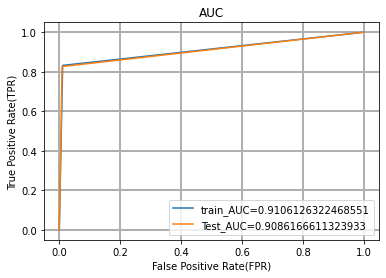

In [ ]:
train_fpr,train_tpr,tr_thresholds = roc_curve(y_train,y_pred)
test_fpr,test_tpr,te_thresholds = roc_curve(y_test,y_test_pred)
plt.plot(train_fpr,train_tpr,label = "train_AUC="+str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr,label = "Test_AUC="+str(auc(test_fpr,test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("AUC")
plt.grid(linestyle='-', linewidth=2)

In [ ]:
print("f1-score:",f1_score(y_test,y_test_pred))

f1-score: 0.8972096351061292


**Logistic Regression**

In [ ]:
#ref https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
parameters = {'penalty':['l1', 'l2'], 'C':[0.001,0.01,0.1,1,10],'solver':['liblinear','saga','sag']}
rkf = StratifiedKFold(n_splits=11,random_state=42,shuffle=True)
clf = LogisticRegression(random_state=42)

grid = GridSearchCV(estimator = clf, param_grid = parameters , scoring = 'roc_auc', verbose = 1, n_jobs = -1,cv=rkf)
grid.fit(X_train,y_train)


print("Best Score:" + str(grid.best_score_))
print("Best Parameters: " + str(grid.best_params_))




Fitting 11 folds for each of 30 candidates, totalling 330 fits
Best Score:0.9707054340363939
Best Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}


In [ ]:
clf = LogisticRegression(C=10,penalty='l2',solver='liblinear')
clf.fit(X_train,y_train)

y_pred = clf.predict(X_train)
logistic_train_auc = roc_auc_score(y_train,y_pred)
print(logistic_train_auc)

0.9160849283940161


In [ ]:
y_test_pred = clf.predict(X_test)
logistic_test_auc = roc_auc_score(y_test,y_test_pred)
print(logistic_test_auc)

0.9153195435439326


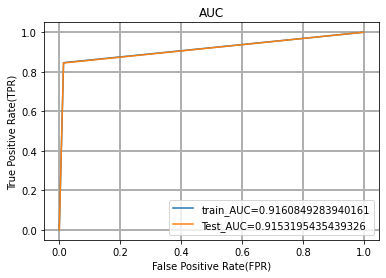

In [ ]:
train_fpr,train_tpr,tr_thresholds = roc_curve(y_train,y_pred)
test_fpr,test_tpr,te_thresholds = roc_curve(y_test,y_test_pred)
plt.plot(train_fpr,train_tpr,label = "train_AUC="+str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr,label = "Test_AUC="+str(auc(test_fpr,test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("AUC")
plt.grid(linestyle='-', linewidth=2)

In [ ]:
print("f1-score:",f1_score(y_test,y_test_pred))

f1-score: 0.9040451552210724


**Naive Bayes Classifier**

In [ ]:
from sklearn.naive_bayes import MultinomialNB

In [ ]:
#ref https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

parameters = {'alpha':[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]}

rkf = StratifiedKFold(n_splits=11,random_state=42,shuffle=True)
clf = MultinomialNB()

grid = GridSearchCV(estimator = clf, param_grid = parameters, scoring = 'roc_auc', verbose = 1, n_jobs = -1,cv=rkf)
grid.fit(X_train,y_train)

print("Best Score:" + str(grid.best_score_))
print("Best Parameters: " + str(grid.best_params_))

Fitting 11 folds for each of 9 candidates, totalling 99 fits
Best Score:0.8615649736325582
Best Parameters: {'alpha': 1000}


In [ ]:
clf = MultinomialNB(alpha=1000)
clf.fit(X_train,y_train)

y_pred = clf.predict(X_train)
multinomial_train_auc = roc_auc_score(y_train,y_pred)
print(multinomial_train_auc)

0.6636754685878632


In [ ]:
y_test_pred = clf.predict(X_test)
multinomial_test_auc = roc_auc_score(y_test,y_test_pred)
print(multinomial_test_auc)

0.664416737082421


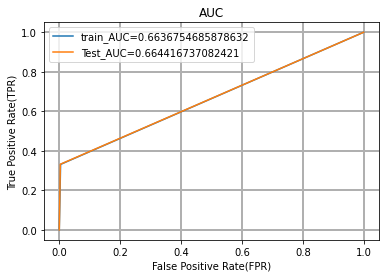

In [ ]:
train_fpr,train_tpr,tr_thresholds = roc_curve(y_train,y_pred)
test_fpr,test_tpr,te_thresholds = roc_curve(y_test,y_test_pred)
plt.plot(train_fpr,train_tpr,label = "train_AUC="+str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr,label = "Test_AUC="+str(auc(test_fpr,test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("AUC")
plt.grid(linestyle='-', linewidth=2)

In [ ]:
print("f1-score:",f1_score(y_test,y_test_pred))

f1-score: 0.496551724137931


**Decision Tree Classifier**

In [ ]:
#ref =https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

params =  {'max_depth':[2,3,5,7,9]}

#The instance of SVC
rkf = StratifiedKFold(n_splits=11,random_state=42,shuffle=True)
tree_model = DecisionTreeClassifier(random_state=42)
#Used GridserachCV for Hyper-parameter
grid = GridSearchCV(estimator = tree_model, param_grid = params, scoring = 'roc_auc', verbose = 1, n_jobs = -1,cv=rkf)
grid.fit(X_train,y_train)

print("Best Score:" + str(grid.best_score_))
print("Best Parameters: " + str(grid.best_params_))





Fitting 11 folds for each of 5 candidates, totalling 55 fits
Best Score:0.9516458538537644
Best Parameters: {'max_depth': 9}


In [ ]:
tree_clf = DecisionTreeClassifier(max_depth=9)
tree_clf.fit(X_train,y_train)

y_pred = tree_clf.predict(X_train)
tree_train_auc = roc_auc_score(y_train,y_pred)
print(tree_train_auc)


0.9162501703755764


In [ ]:
y_test_pred = tree_clf.predict(X_test)
tree_test_auc = roc_auc_score(y_test,y_test_pred)
print(tree_test_auc)

0.9094607503034852


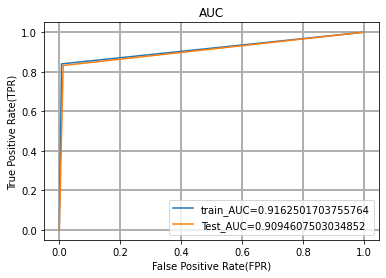

In [ ]:
train_fpr,train_tpr,tr_thresholds = roc_curve(y_train,y_pred)
test_fpr,test_tpr,te_thresholds = roc_curve(y_test,y_test_pred)
plt.plot(train_fpr,train_tpr,label = "train_AUC="+str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr,label = "Test_AUC="+str(auc(test_fpr,test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("AUC")
plt.grid(linestyle='-', linewidth=2)

In [ ]:
print("F1-score:",f1_score(y_test,y_test_pred))

F1-score: 0.8973690447973452


**Gradient Boosting Algorithm**

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
params = {'n_estimators': [10,20,30,40,50,60],'max_depth':[2,3,5,7]}
rkf = StratifiedKFold(n_splits=11,random_state=42,shuffle=True)
gbdt_model = GradientBoostingClassifier(random_state=42)
#Used GridserachCV for Hyper-parameter
grid = GridSearchCV(estimator = gbdt_model, param_grid = params, scoring = 'roc_auc', verbose = 1, n_jobs = -1,cv=rkf)
grid.fit(X_train,y_train)

print("Best Score:" + str(grid.best_score_))
print("Best Parameters: " + str(grid.best_params_))


Fitting 11 folds for each of 24 candidates, totalling 264 fits
Best Score:0.9757435926029662
Best Parameters: {'max_depth': 5, 'n_estimators': 60}


In [ ]:
gbdt_clf = GradientBoostingClassifier(max_depth = 5, n_estimators = 60)
gbdt_clf.fit(X_train,y_train)

y_pred = gbdt_clf.predict(X_train)
gbdt_train_auc = roc_auc_score(y_train,y_pred)
print(gbdt_train_auc)

0.9228726871414403


In [ ]:
y_test_pred = gbdt_clf.predict(X_test)
gbdt_test_auc = roc_auc_score(y_test,y_test_pred)
print(gbdt_test_auc)

0.9158091917531228


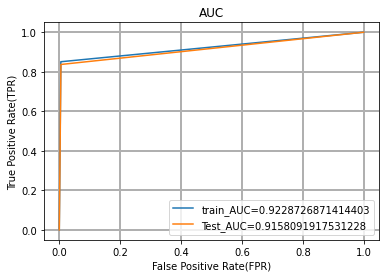

In [ ]:
train_fpr,train_tpr,tr_thresholds = roc_curve(y_train,y_pred)
test_fpr,test_tpr,te_thresholds = roc_curve(y_test,y_test_pred)
plt.plot(train_fpr,train_tpr,label = "train_AUC="+str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr,label = "Test_AUC="+str(auc(test_fpr,test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("AUC")
plt.grid(linestyle='-', linewidth=2)

In [ ]:
print("f1-score:",f1_score(y_test,y_test_pred))

f1-score: 0.9067110899571633


**Stacking Classifier**

In [53]:
import six
import sys
sys.modules['sklearn.externals.six'] = six

In [54]:
from mlxtend.classifier import StackingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

In [56]:
#classifier 1
knn_model = KNeighborsClassifier(n_neighbors = 7)
knn_model.fit(X_train,y_train)

#Classifier 2
model = LogisticRegression(C= 10, penalty = 'l2', solver = 'liblinear')
model.fit(X_train,y_train)

#classifier 3
naive_clf = MultinomialNB(alpha=1000)
naive_clf.fit(X_train,y_train)



#classifier 4


tree_clf = DecisionTreeClassifier(max_depth = 9)
tree_clf.fit(X_train,y_train)

#classifier 5
gbdt_clf = GradientBoostingClassifier(max_depth = 5, n_estimators = 60)
gbdt_clf.fit(X_train,y_train)


#Stacking Classifer

sclf = StackingClassifier(classifiers=[knn_model,model,naive_clf,tree_clf,gbdt_clf],meta_classifier=model)

#fit the model
sclf.fit(X_train,y_train)

#predict in probabilities

y_pred = sclf.predict(X_train)


In [57]:
train_auc = roc_auc_score(y_train,y_pred)
print(train_auc)

0.9228726871414403


In [58]:
y_test_pred = sclf.predict(X_test)
test_auc = roc_auc_score(y_test,y_test_pred)
print(test_auc)

0.9161205508716705


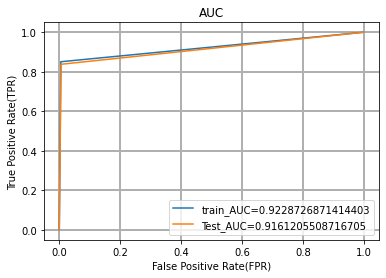

In [59]:
train_fpr,train_tpr,tr_thresholds = roc_curve(y_train,y_pred)
test_fpr,test_tpr,te_thresholds = roc_curve(y_test,y_test_pred)
plt.plot(train_fpr,train_tpr,label = "train_AUC="+str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr,label = "Test_AUC="+str(auc(test_fpr,test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("AUC")
plt.grid(linestyle='-', linewidth=2)

In [60]:
print("F1 score:",f1_score(y_test,y_test_pred))

F1 score: 0.9070154577883471


### Summary of All Models

In [2]:
from texttable import Texttable
t = Texttable()
t.add_rows([['Model','Hyper-parameter','Train AUC','Test AUC','f1_score'],['Knn_Model',r"{'n_neighbors': 7}",0.90,0.91,0.89],
           ['logistic Regresstion',r"{'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}",0.91,0.91,0.90],
            ['Gradient Boosting Algorithm',r"{'max_depth': 5, 'n_estimators': 60}",0.92,0.91,0.90],
            ['Decision_tree Model',r"{'max_depth': 9}",0.91,0.90,0.89],
            ['Naive Bayes',r"{'alpha': 0.1}",0.66,0.66,0.49],
            ['Calibrated Model',"--",0.92,0.91,0.90]])

print(t.draw())



+----------------------+---------------------+-----------+----------+----------+
|        Model         |   Hyper-parameter   | Train AUC | Test AUC | f1_score |
+======================+=====================+===========+==========+==========+
| Knn_Model            | {'n_neighbors': 7}  | 0.900     | 0.910    | 0.890    |
+----------------------+---------------------+-----------+----------+----------+
| logistic Regresstion | {'C': 10,           | 0.910     | 0.910    | 0.900    |
|                      | 'penalty': 'l2',    |           |          |          |
|                      | 'solver':           |           |          |          |
|                      | 'liblinear'}        |           |          |          |
+----------------------+---------------------+-----------+----------+----------+
| Gradient Boosting    | {'max_depth': 5,    | 0.920     | 0.910    | 0.900    |
| Algorithm            | 'n_estimators': 60} |           |          |          |
+----------------------+----

### Observation

We have done text-preprcoessing technique on SQL query and apply Word2Vec to come up with vectorization. 

We have applied 6 Machine learning model such as Knn_Model, Logistic Regression,Gradient Boosting algorithm, Decision_tree model, Naive Bayes Model and calibrated model.

Used AUC as evaluation metrics.

We found calibrated model as best model with Test AUC =0.91 for this experiment.